In [1]:
import numpy as np
import time
from scipy.spatial.transform import Rotation as R
import matplotlib.pyplot as plt
import numpy.linalg as LA

In [2]:
def Superpose3D_original(aaXf_orig,  # <-- coordinates for the "frozen" object
                aaXm_orig,  # <-- coordinates for the "mobile" object
                aWeights=None,  # <- optional weights for the calculation of RMSD
                allow_rescale=False):  # <-- attempt to rescale mobile object?
    """
    Superpose3D() takes two lists of xyz coordinates, (of the same length)
    and attempts to superimpose them using rotations, translations, and
    (optionally) rescale operations in order to minimize the
    root-mean-squared-distance (RMSD) between them.
    These operations should be applied to the "aaXm_orig" argument.
    This function returns a tuple containing:
      (RMSD, optimal_translation, optimal_rotation, and optimal_scale_factor)
    This function implements a more general variant of the method from:
    R. Diamond, (1988)
    "A Note on the Rotational Superposition Problem",
    Acta Cryst. A44, pp. 211-216
    This version has been augmented slightly.  The version in the original
    paper only considers rotation and translation and does not allow the
    coordinates of either object to be rescaled (multiplication by a scalar).
    (Additional documentation can be found at
     https://pypi.org/project/superpose3d/ )
    """

    assert (len(aaXf_orig) == len(aaXm_orig))
    N = len(aaXf_orig)
    if (aWeights == None) or (len(aWeights) == 0):
        aWeights = np.full(N, 1.0)

    # Find the center of mass of each object:
    aCenter_f = np.zeros(3)
    aCenter_m = np.zeros(3)
    sum_weights = 0.0
    for n in range(0, N):
        for d in range(0, 3):
            aCenter_f[d] += aaXf_orig[n][d] * aWeights[n]
            aCenter_m[d] += aaXm_orig[n][d] * aWeights[n]
        sum_weights += aWeights[n]
    for d in range(0, 3):
        aCenter_f[d] /= sum_weights
        aCenter_m[d] /= sum_weights

    # Subtract the centers-of-mass from the original coordinates for each object
    aaXf = np.empty((N, 3))
    aaXm = np.empty((N, 3))
    aaXf[0][0] = 0.0
    for n in range(0, N):
        for d in range(0, 3):
            aaXf[n][d] = aaXf_orig[n][d] - aCenter_f[d]
            aaXm[n][d] = aaXm_orig[n][d] - aCenter_m[d]

    # Calculate the "M" array from the Diamond paper (equation 16)
    M = np.zeros((3, 3))
    for n in range(0, N):
        for i in range(0, 3):
            for j in range(0, 3):
                M[i][j] += aWeights[n] * aaXm[n][i] * aaXf[n][j]

    # Calculate Q (equation 17)
    traceM = 0.0
    for i in range(0, 3):
        traceM += M[i][i]

    Q = np.empty((3, 3))
    for i in range(0, 3):
        for j in range(0, 3):
            Q[i][j] = M[i][j] + M[j][i]
            if i == j:
                Q[i][j] -= 2.0 * traceM

    # Calculate V (equation 18)
    V = np.empty(3)
    V[0] = M[1][2] - M[2][1];
    V[1] = M[2][0] - M[0][2];
    V[2] = M[0][1] - M[1][0];

    # Calculate "P" (equation 22)
    P = np.empty((4, 4))
    for i in range(0, 3):
        for j in range(0, 3):
            P[i][j] = Q[i][j]
    P[0][3] = V[0]
    P[3][0] = V[0]
    P[1][3] = V[1]
    P[3][1] = V[1]
    P[2][3] = V[2]
    P[3][2] = V[2]
    P[3][3] = 0.0

    aEigenvals, aaEigenvects = LA.eigh(P)

    # http://docs.scipy.org/doc/numpy/reference/generated/numpy.linalg.eigh.html

    eval_max = aEigenvals[0]
    i_eval_max = 0
    for i in range(1, 4):
        if aEigenvals[i] > eval_max:
            eval_max = aEigenvals[i]
            i_eval_max = i

    # The vector "p" contains the optimal rotation (in quaternion format)
    p = np.empty(4)
    p[0] = aaEigenvects[0][i_eval_max]
    p[1] = aaEigenvects[1][i_eval_max]
    p[2] = aaEigenvects[2][i_eval_max]
    p[3] = aaEigenvects[3][i_eval_max]

    # normalize the vector
    # (It should be normalized already, but just in case it is not, do it again)
    pnorm = np.linalg.norm(p)
    for i in range(0, 4):
        p[i] /= pnorm

    # Finally, calculate the rotation matrix corresponding to "p"
    # (convert a quaternion into a 3x3 rotation matrix)
    aaRotate = np.empty((3, 3))

    aaRotate[0][0] = (p[0] * p[0]) - (p[1] * p[1]) - (p[2] * p[2]) + (p[3] * p[3])
    aaRotate[1][1] = -(p[0] * p[0]) + (p[1] * p[1]) - (p[2] * p[2]) + (p[3] * p[3])
    aaRotate[2][2] = -(p[0] * p[0]) - (p[1] * p[1]) + (p[2] * p[2]) + (p[3] * p[3])
    aaRotate[0][1] = 2 * (p[0] * p[1] - p[2] * p[3]);
    aaRotate[1][0] = 2 * (p[0] * p[1] + p[2] * p[3]);
    aaRotate[1][2] = 2 * (p[1] * p[2] - p[0] * p[3]);
    aaRotate[2][1] = 2 * (p[1] * p[2] + p[0] * p[3]);
    aaRotate[0][2] = 2 * (p[0] * p[2] + p[1] * p[3]);
    aaRotate[2][0] = 2 * (p[0] * p[2] - p[1] * p[3]);

    pPp = eval_max

    # Optional: Decide the scale factor, c
    c = 1.0  # by default, don't rescale the coordinates
    if allow_rescale:
        Waxaixai = 0.0
        WaxaiXai = 0.0
        for a in range(0, N):
            for i in range(0, 3):
                Waxaixai += aWeights[a] * aaXm[a][i] * aaXm[a][i]
                WaxaiXai += aWeights[a] * aaXm[a][i] * aaXf[a][i]
        c = (WaxaiXai + pPp) / Waxaixai

    # Finally compute the RMSD between the two coordinate sets:
    # First compute E0 from equation 24 of the paper
    E0 = 0.0
    for n in range(0, N):
        for d in range(0, 3):
            # (remember to include the scale factor "c" that we inserted)
            E0 += aWeights[n] * ((aaXf[n][d] - c * aaXm[n][d]) ** 2)
    sum_sqr_dist = E0 - c * 2.0 * pPp
    if sum_sqr_dist < 0.0:  # (edge case due to rounding error)
        sum_sqr_dist = 0.0
    rmsd = np.sqrt(sum_sqr_dist / sum_weights)

    # Lastly, calculate the translational offset:
    # Recall that:
    # RMSD=sqrt((Σ_i  w_i * |X_i - (Σ_j c*R_ij*x_j + T_i))|^2) / (Σ_j w_j))
    #    =sqrt((Σ_i  w_i * |X_i - x_i'|^2) / (Σ_j w_j))
    #  where
    # x_i' = Σ_j c*R_ij*x_j + T_i
    #      = Xcm_i + c*R_ij*(x_j - xcm_j)
    #  and Xcm and xcm = center_of_mass for the frozen and mobile point clouds
    #                  = aCenter_f[]       and       aCenter_m[],  respectively
    # Hence:
    #  T_i = Xcm_i - Σ_j c*R_ij*xcm_j  =  aTranslate[i]

    aTranslate = np.empty(3)
    for i in range(0, 3):
        aTranslate[i] = aCenter_f[i]
        for j in range(0, 3):
            aTranslate[i] -= c * aaRotate[i][j] * aCenter_m[j]

    # An alternate method to compute "aTranslate" using numpy matrices:
    # Rmatrix = np.matrix(aaRotate)
    # TcolumnVec = np.matrix(np.empty((3,1))) # 3x1 numpy matrix<->[[0],[0],[0]]
    # for d in range(0,3):
    #    TcolumnVec[d][0] = -aCenter_m[d]
    # TcolumnVec = c * Rmatrix * TcolumnVec
    # for d in range(0,3):
    #    TcolumnVec[d][0] += aCenter_f[d]
    # #Turn the column vector back into an ordinary numpy array of size 3:
    # aTranslate = np.array(TcolumnVec.transpose())[0]

    return rmsd, aaRotate, aTranslate, c

In [7]:
def Superpose3D_v2(aaXf_orig,   # <-- coordinates for the "frozen" object
                aaXm_orig,   # <-- coordinates for the "mobile" object
                # ---- optional arguments: ----
                aWeights=None,   # optional weights for the calculation of RMSD
                allow_rescale=False,   # attempt to rescale mobile point cloud?
                report_quaternion=False):     # report rotation angle and axis

    aaXf_orig = np.array(aaXf_orig)
    aaXm_orig = np.array(aaXm_orig)

    if aaXf_orig.shape[0] != aaXm_orig.shape[0]:
        raise ValueError ("Inputs should have the same size.")
        
    N = aaXf_orig.shape[0]
    if (aWeights == None) or (len(aWeights) == 0):
        aWeights = np.full((N,1),1.0)
    else:
        aWeights = np.array(aWeights).reshape(N,1)

    aCenter_f = np.sum(aaXf_orig * aWeights, axis=0)
    aCenter_m = np.sum(aaXm_orig * aWeights, axis=0)
    sum_weights = np.sum(aWeights, axis=0)

    if sum_weights != 0:
        aCenter_f /= sum_weights
        aCenter_m /= sum_weights

    aaXf = aaXf_orig-aCenter_f
    aaXm = aaXm_orig-aCenter_m

    M = aaXm.T @ (aaXf * aWeights)
    Q = M + M.T - 2*np.eye(3)*np.trace(M)

    V = np.empty(3)
    V[0] = M[1][2] - M[2][1];
    V[1] = M[2][0] - M[0][2];
    V[2] = M[0][1] - M[1][0];

    P = np.zeros((4,4))
    P[:3, :3] = Q
    P[3,:3] = V
    P[:3, 3] = V

    p = np.zeros(4)
    p[3] = 1.0           # p = [0,0,0,1]    default value
    pPp = 0.0            # = p^T * P * p    (zero by default)
    singular = (N < 2)   # (it doesn't make sense to rotate a single point)

    try:
        aEigenvals, aaEigenvects = LA.eigh(P)

    except LinAlgError:
        singular = True  # (I have never seen this happen.)

    if (not singular):  # (don't crash if the caller supplies nonsensical input)

        i_eval_max = np.argmax(aEigenvals)
        pPp = np.max(aEigenvals)
        p[:] = aaEigenvects[:, i_eval_max]
        
    p /= np.linalg.norm(p)

    the_rotation = R.from_quat(p)
    aaRotate = the_rotation.as_matrix()
    
    c = 1.0   # by default, don't rescale the coordinates
    if allow_rescale and (not singular):

        Waxaixai = np.sum(aWeights * aaXm ** 2)
        WaxaiXai = np.sum(aWeights * aaXf ** 2)

        c = (WaxaiXai + pPp) / Waxaixai

    E0 = np.sum((aaXf - c*aaXm)**2)
    sum_sqr_dist = max(0, E0 - c * 2.0 * pPp)

    rmsd = 0.0
    if sum_weights != 0.0:
        rmsd = np.sqrt(sum_sqr_dist/sum_weights)

    aTranslate = aCenter_f - (c*aaRotate @ aCenter_m).T.reshape(3,)

    if report_quaternion: # does the caller want the quaternion?
        q = np.empty(4)
        q[0] = p[3]  # Note: The "p" variable is not a quaternion in the
        q[1] = p[0]  #       conventional sense because its elements
        q[2] = p[1]  #       are in the wrong order.  I correct for that here.
        q[3] = p[2]  #       "q" is the quaternion correspond to rotation R
        return rmsd, q, aTranslate, c
    else:
        return rmsd, aaRotate, aTranslate, c

In [4]:
data1 = np.random.random((10000,3))
data2 = data1+0.01*np.random.random((10000,3)) #creating fake data with some noise.
the_rotation = R.from_euler('xyz', [30,30,30])
data2 = the_rotation.apply(data2) + np.array([0.2,-0.3,0.5])

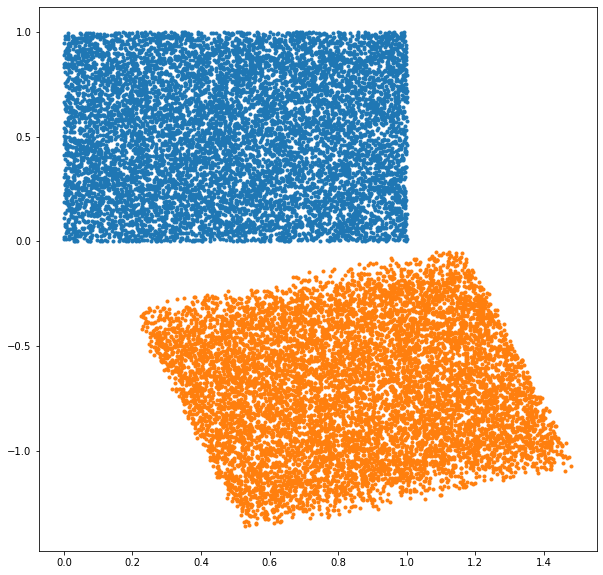

In [5]:
plt.figure(figsize=(10,10))
plt.plot(data1[:,0], data1[:,1], "o", ms = 3)
plt.plot(data2[:,0], data2[:,1], "o",ms = 3)

In [19]:
limits = [10, 20, 30, 50, 100,150, 300,500, 1000,2000,3000,5000,10000]

times_original = []
times_v2 = []

for limit in limits:
    
    temp_original = []
    temp_v2 = []
    
    for _ in range (20):
        initial = time.time()
        _, rot1, trans1, _ = Superpose3D_original(data1[:limit],data2[:limit])
        final = time.time()

        temp_original.append(final-initial)

        initial = time.time()
        _, rot2, trans2, _ = Superpose3D_v2(data1[:limit],data2[:limit])
        final = time.time()
        
        temp_v2.append(final-initial)
        
    times_original.append(np.mean(temp_original))
    times_v2.append(np.mean(temp_v2))
    


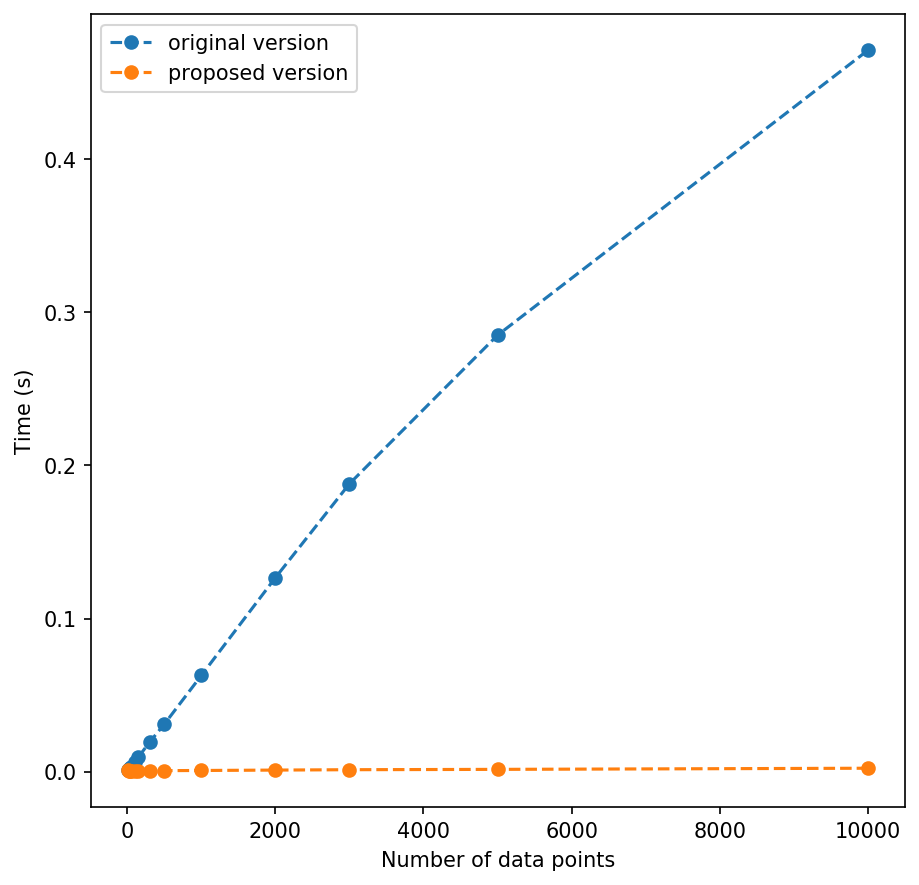

In [20]:
plt.figure(figsize = (7,7), dpi=150)
plt.plot(limits,times_original, "o--", label = "original version")
plt.plot(limits,times_v2, "o--", label = "proposed version")
plt.xlabel("Number of data points")
plt.ylabel("Time (s)")
plt.legend()

plt.savefig("times.pdf")

In [21]:
import test_superpose3d

In [23]:
test_superpose3d.test_superpose3d()

 (quaternion = [ 0.70239529  0.71178469 -0.00097423  0.00157255])

1st (frozen) point cloud:
[[0, 0, 0], [0, 0, 1], [0, 1, 1], [1, 1, 1]]
2nd (mobile) point cloud:
[[0, 200, 0], [0, 202.1, 0], [0, 202, -2], [2, 202, -2]]
2nd (mobile) point cloud after scale(c), rotation(R), translation(T):
[[-0.04671682 -0.0890972  -0.1756188 ]
 [-0.05125589 -0.10585979  1.0865216 ]
 [-0.05208566  1.09698428  1.04238038]
 [ 1.15005837  1.09797271  1.04671682]]
rmsd = [0.16620452]
scale (c) = 0.601076131135872
rotation (R) = 
[[ 9.99993156e-01 -3.59598928e-03  8.70039606e-04]
 [ 8.22214121e-04 -1.32798221e-02 -9.99911481e-01]
 [ 3.60722494e-03  9.99905353e-01 -1.32767746e-02]]
translation (T) = [   0.38557585    1.50733962 -120.37946703]
transformation used: x_i' = Sum_over_j c*R_ij*x_j + T_i
